In [1]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.base import clone
from catboost import CatBoostRegressor
import plotly.graph_objects as go
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import matplotlib
import numpy as np
import warnings
import optuna
import json

matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
SEED = 42
N_FOLDS = 5
N_REPEATS = 3
N_OPTUNA_TRIALS = 100

DATASET_PATH = '/kaggle/input/kode24-lnnstall/2024.csv'

In [3]:
dataset = pd.read_csv(DATASET_PATH)
dataset = dataset.dropna(subset=['lønn'])

In [4]:
dataset

,kjønn,utdanning,erfaring,arbeidssted,arbeidssituasjon,fag,lønn,bonus?
0,mann,4,7,Agder,"in-house, privat sektor",AI / maskinlæring,865000,Nei
1,mann,5,2,Nordland,"in-house, offentlig/kommunal sektor",AI / maskinlæring,756000,Nei
2,mann,4,30,Oslo,konsulent,AI / maskinlæring,1500000,Nei
3,mann,5,25,Oslo,konsulent,AI / maskinlæring,1200000,Nei
4,mann,9,18,Oslo,"in-house, privat sektor",AI / maskinlæring,1200000,Nei
...,...,...,...,...,...,...,...,...
2677,mann,3,14,Vestfold og Telemark,"in-house, offentlig/kommunal sektor",UX / design,720000,Nei
2678,mann,5,8,Vestland,konsulent,UX / design,875000,Nei
2679,mann,0,23,Viken,"in-house, privat sektor",UX / design,1300000,Nei
2680,mann,3,15,Viken,konsulent,UX / design,1000000,Ja


# Topp 10 best betalte

In [5]:
dataset.sort_values(by='lønn', ascending=False).head(10)

,kjønn,utdanning,erfaring,arbeidssted,arbeidssituasjon,fag,lønn,bonus?
1594,mann,0,13,Oslo,konsulent,fullstack,2700000,Ja
1079,mann,4,30,Viken,"in-house, privat sektor",embedded / IOT / maskinvare,2600000,Ja
2377,mann,3,9,Oslo,konsulent,ledelse/administrativt,2500000,Ja
2470,mann,5,20,Oslo,frilans / selvstendig næringsdrivende,programvare,2500000,Nei
1545,mann,5,19,Oslo,konsulent,fullstack,2500000,Ja
261,mann,5,17,Viken,frilans / selvstendig næringsdrivende,arkitektur,2500000,Nei
405,mann,3,14,Oslo,frilans / selvstendig næringsdrivende,backend,2500000,Nei
2208,mann,5,14,Vestland,konsulent,fullstack,2500000,Ja
258,mann,3,25,Viken,frilans / selvstendig næringsdrivende,arkitektur,2450000,Nei
1617,mann,5,11,Oslo,frilans / selvstendig næringsdrivende,fullstack,2400000,Nei


# Topp 10 dårlegast betalte

In [6]:
dataset.sort_values(by='lønn', ascending=False).tail(10)

,kjønn,utdanning,erfaring,arbeidssted,arbeidssituasjon,fag,lønn,bonus?
608,kvinne,2,1,Oslo,"in-house, privat sektor",backend,437000,Nei
1309,mann,0,3,Rogaland,konsulent,frontend,430000,Nei
2618,mann,3,2,Oslo,konsulent,testing,430000,Nei
612,mann,3,1,Oslo,"in-house, privat sektor",backend,429000,Nei
2304,mann,4,2,Viken,"in-house, privat sektor",fullstack,420000,Nei
2538,annet / ønsker ikke oppgi,4,1,Innlandet,"in-house, offentlig/kommunal sektor",sikkerhet,415000,Nei
1397,mann,0,1,Vestland,"in-house, privat sektor",frontend,370000,Nei
298,mann,3,0,Vestland,"in-house, privat sektor",automatisering,350000,Nei
82,mann,3,12,Vestland,"in-house, privat sektor",annet,310000,Nei
1445,mann,3,1,Agder,frilans / selvstendig næringsdrivende,fullstack,300000,Nei


# Best betalte stillinger

In [7]:
avg_salaries_by_job_type = dataset.groupby('fag')['lønn'].mean().reset_index().sort_values(by='lønn', ascending=True)

fig = px.bar(
    avg_salaries_by_job_type,
    y='fag', 
    x='lønn',  
    color='lønn',
    color_continuous_scale='RdYlGn',
    labels={'fag': 'Fag', 'lønn': 'Gjennomsnittsløn (NOK)'}
)

fig.update_layout(
    xaxis_title='Gjennomsnittsløn (NOK)',
    yaxis_title='Fag',
    width=800,
    height=400,
    font=dict(size=10)
)

for i, row in avg_salaries_by_job_type.iterrows():
    fig.add_annotation(
        x=row['lønn'],
        y=row['fag'],
        text=f'{row["lønn"]:,.0f} NOK',
        showarrow=False,
        font=dict(color='black', size=10),
        xshift=-60 
    )

fig.update_coloraxes(showscale=False)
fig.show()


In [8]:
avg_salary_by_fag = dataset.groupby('fag')['lønn'].mean().reset_index()
sorted_fag = avg_salary_by_fag.sort_values(by='lønn', ascending=True)['fag']
dataset_sorted = dataset.set_index('fag').loc[sorted_fag].reset_index()

fig = px.box(
    dataset_sorted,
    x='lønn',  
    y='fag',    
    width=800, 
    height=400
)

fig.update_layout(
    xaxis_title='Løn (NOK)', 
    yaxis_title='Fag',      
    xaxis_range=[0, 2_400_000], 
    font=dict(size=10)
)

fig.show()

# Kvar lønnar det seg å jobbe?

In [9]:
avg_salaries_by_city = dataset.groupby('arbeidssted')['lønn'].mean().reset_index().sort_values(by='lønn', ascending=True)

fig = px.bar(
    avg_salaries_by_city,
    y='arbeidssted', 
    x='lønn',  
    color='lønn',
    color_continuous_scale='RdYlGn',
    labels={'arbeidssted': 'Fylke', 'lønn': 'Gjennomsnittsløn (NOK)'}
)

fig.update_layout(
    xaxis_title='Gjennomsnittsløn (NOK)',
    yaxis_title='Fylke',
    width=800,
    height=400,
    font=dict(size=10)
)

for i, row in avg_salaries_by_city.iterrows():
    fig.add_annotation(
        x=row['lønn'],
        y=row['arbeidssted'],
        text=f'{row["lønn"]:,.0f} NOK',
        showarrow=False,
        font=dict(color='black', size=10),
        xshift=-60 
    )

fig.update_coloraxes(showscale=False)
fig.show()


In [10]:
avg_salary_by_city = dataset.groupby('arbeidssted')['lønn'].mean().reset_index()
sorted_city = avg_salary_by_city.sort_values(by='lønn', ascending=True)['arbeidssted']
dataset_sorted = dataset.set_index('arbeidssted').loc[sorted_city].reset_index()

fig = px.box(
    dataset_sorted,
    x='lønn',  
    y='arbeidssted',    
    width=800, 
    height=400, 
)

fig.update_layout(
    xaxis_title='Løn (NOK)', 
    yaxis_title='Fylke',      
    xaxis_range=[0, 2_400_000], 
    font=dict(size=10)
)

fig.show()

# Erfaring og utdanning

In [11]:
cleaned_data = dataset.dropna(subset=['erfaring', 'lønn'])
cleaned_data['lønn'] = cleaned_data['lønn'].astype(float)
avg_salary_by_experience = cleaned_data.groupby('erfaring')['lønn'].mean().reset_index()
lowest_point = avg_salary_by_experience.loc[avg_salary_by_experience['lønn'].idxmin()]
highest_point = avg_salary_by_experience.loc[avg_salary_by_experience['lønn'].idxmax()]

fig = px.line(
    avg_salary_by_experience,
    x='erfaring',
    y='lønn',
    labels={'erfaring': 'Erfaring', 'lønn': 'Gjennomsnittsløn (NOK)'}
)


fig.add_trace(
    go.Scatter(
        x=[lowest_point['erfaring']],
        y=[lowest_point['lønn']],
        mode='markers+text',
        marker=dict(color='red', size=10),
        name='Lågast løn',
        text=[f'Lågast løn: {lowest_point["lønn"]:,.0f} NOK, Erfaring: {int(lowest_point["erfaring"])} år'],
        textfont=dict(size=10, color='red'),
        textposition='bottom right'
    )
)
fig.add_trace(
    go.Scatter(
        x=[highest_point['erfaring']],
        y=[highest_point['lønn']],
        mode='markers+text',
        marker=dict(color='green', size=10),
        name='Høgest løn',
        text=[f'Høgast løn: {highest_point["lønn"]:,.0f} NOK, Erfaring: {int(highest_point["erfaring"])} år'],
        textfont=dict(size=10, color='green'),
        textposition='top center'
    )
)

fig.update_layout(
    xaxis_title='Erfaring',
    yaxis_title='Gjennomsnittsløn (NOK)',
    width=800,
    height=400,
    font=dict(size=10)
)

fig.update_layout(showlegend=False)
fig.show()

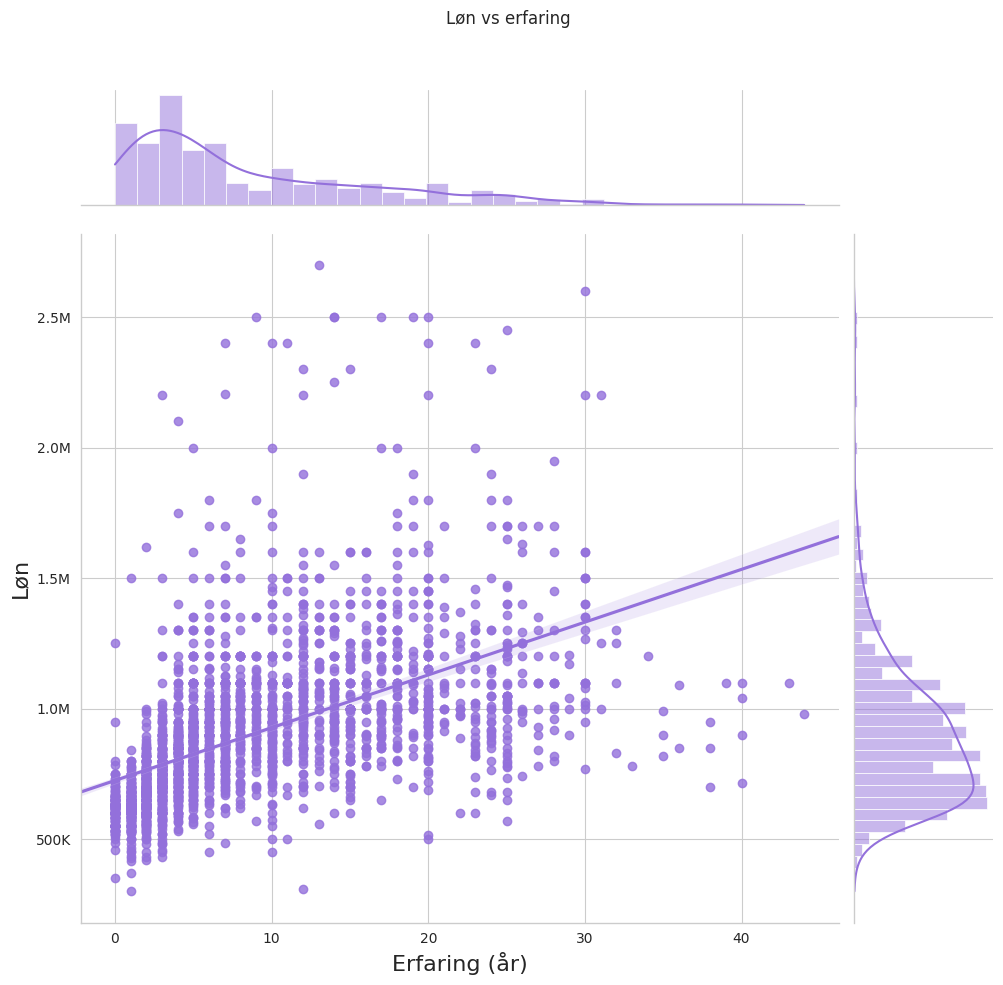

In [12]:
def currency_format(x, pos):
    'The two args are the value and tick position'
    if x >= 1e6:
        s = '{:.1f}M'.format(x*1e-6)
    else:
        s = '{:.0f}K'.format(x*1e-3)
    return s

sns.set_style('whitegrid')
g = sns.jointplot(
    x='erfaring',
    y='lønn',
    data=dataset,
    kind='reg',
    truncate=False,
    color='#9370DB',
    height=10,
)
g.set_axis_labels('Erfaring (år)', 'Løn', fontsize=16)
g.fig.suptitle('Løn vs erfaring')
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)

g.ax_joint.yaxis.set_major_formatter(mtick.FuncFormatter(currency_format))

In [13]:
cleaned_data = dataset.dropna(subset=['utdanning', 'lønn'])
cleaned_data['lønn'] = cleaned_data['lønn'].astype(float)
avg_salary_by_edu = cleaned_data.groupby('utdanning')['lønn'].mean().reset_index()
lowest_point = avg_salary_by_edu.loc[avg_salary_by_edu['lønn'].idxmin()]
highest_point = avg_salary_by_edu.loc[avg_salary_by_edu['lønn'].idxmax()]

fig = px.line(
    avg_salary_by_edu,
    x='utdanning',
    y='lønn',
    labels={'utdanning': 'Utdanning', 'lønn': 'Gjennomsnittslønn (NOK)'}
)


fig.add_trace(
    go.Scatter(
        x=[lowest_point['utdanning']],
        y=[lowest_point['lønn']],
        mode='markers+text',
        marker=dict(color='red', size=10),
        name='Lågast løn',
        text=[f'Lågast løn: {lowest_point["lønn"]:,.0f} NOK, Utdanning: {int(lowest_point["utdanning"])} år'],
        textfont=dict(size=10, color='red'),
        textposition='bottom right'
    )
)
fig.add_trace(
    go.Scatter(
        x=[highest_point['utdanning']],
        y=[highest_point['lønn']],
        mode='markers+text',
        marker=dict(color='green', size=10),
        name='Høgest løn',
        text=[f'Høgast løn: {highest_point["lønn"]:,.0f} NOK, Utdanning: {int(highest_point["utdanning"])} år'],
        textfont=dict(size=10, color='green'),
        textposition='top left'
    )
)

fig.update_layout(
    xaxis_title='Utdanning',
    yaxis_title='Gjennomsnittsløn (NOK)',
    width=800,
    height=400,
    font=dict(size=10)
)

fig.update_layout(showlegend=False)
fig.show()

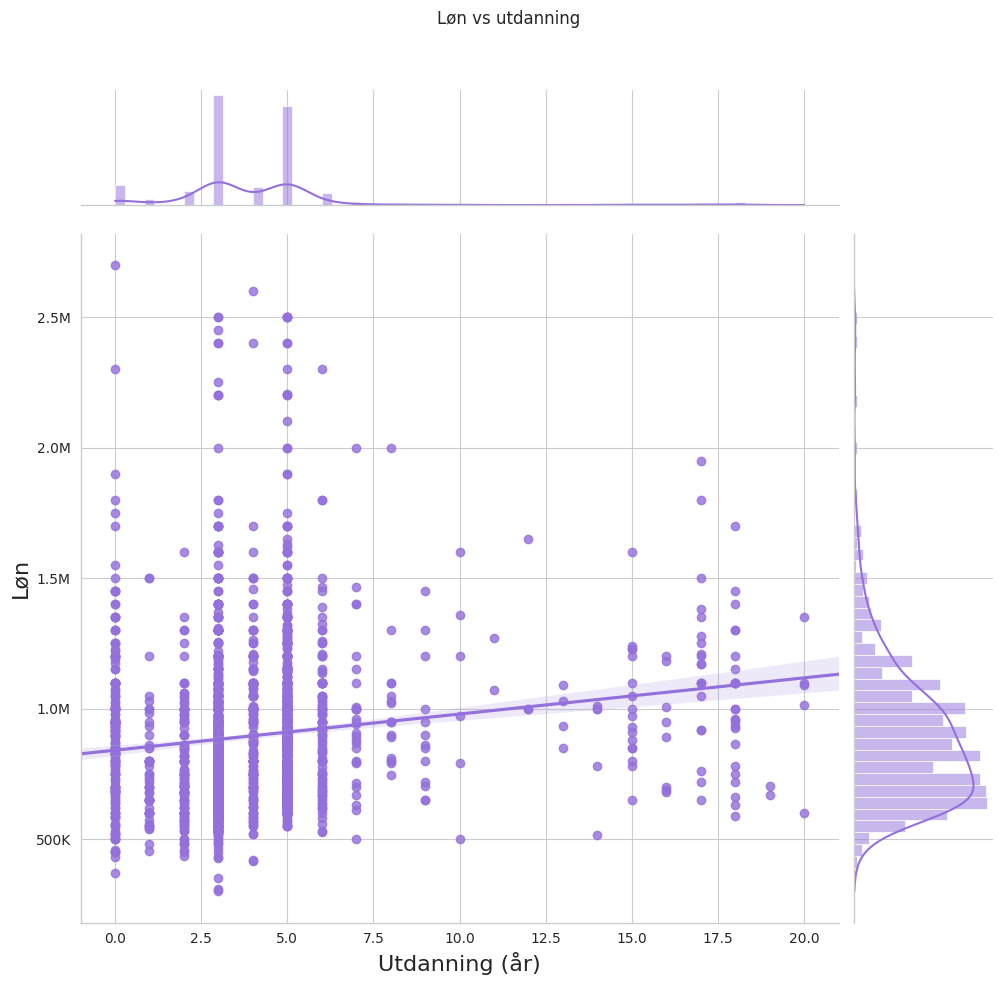

In [14]:
sns.set_style('whitegrid')
g = sns.jointplot(
    x='utdanning',
    y='lønn',
    data=dataset,
    kind='reg',
    truncate=False,
    color='#9370DB',
    height=10
)
g.set_axis_labels('Utdanning (år)', 'Løn', fontsize=16)
g.fig.suptitle('Løn vs utdanning')
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)

g.ax_joint.yaxis.set_major_formatter(mtick.FuncFormatter(currency_format))

# Privat, offentleg, konsulent, eller frilans

In [15]:
avg_salaries_by_employer = dataset.groupby('arbeidssituasjon')['lønn'].mean().reset_index().sort_values(by='lønn', ascending=True)

fig = px.bar(
    avg_salaries_by_employer,
    y='arbeidssituasjon', 
    x='lønn',  
    color='lønn',
    color_continuous_scale='RdYlGn',
    labels={'arbeidssituasjon': 'Jobb', 'lønn': 'Gjennomsnittsløn (NOK)'}
)

fig.update_layout(
    xaxis_title='Gjennomsnittsløn (NOK)',
    yaxis_title='Jobb',
    width=800,
    height=300,
    font=dict(size=10)    
)

for i, row in avg_salaries_by_employer.iterrows():
    fig.add_annotation(
        x=row['lønn'],
        y=row['arbeidssituasjon'],
        text=f'{row["lønn"]:,.0f} NOK',
        showarrow=False,
        font=dict(color='black', size=10),
        xshift=-60 
    )

fig.update_coloraxes(showscale=False)
fig.show()

In [16]:
avg_salaries_by_employer = dataset.groupby('arbeidssituasjon')['lønn'].mean().reset_index()
sorted_city = avg_salaries_by_employer.sort_values(by='lønn', ascending=True)['arbeidssituasjon']
dataset_sorted = dataset.set_index('arbeidssituasjon').loc[sorted_city].reset_index()

fig = px.box(
    dataset_sorted,
    x='lønn',  
    y='arbeidssituasjon',    
    width=800, 
    height=300, 
)

fig.update_layout(
    xaxis_title='Løn (NOK)', 
    yaxis_title='Jobb',  
    font=dict(size=10)    
)

fig.show()

# Lønsforskjellar

In [17]:
avg_salaries_by_gender = dataset.groupby('kjønn')['lønn'].mean().reset_index().sort_values(by='lønn', ascending=True)

fig = px.bar(
    avg_salaries_by_gender,
    y='kjønn', 
    x='lønn',  
    color='lønn',
    color_continuous_scale='RdYlGn',
    labels={'kjønn': 'Kjønn', 'lønn': 'Gjennomsnittsløn (NOK)'}
)

fig.update_layout(
    xaxis_title='Gjennomsnittsløn (NOK)',
    yaxis_title='Kjønn',
    width=800,
    height=300,
    font=dict(size=10)    
)

for i, row in avg_salaries_by_gender.iterrows():
    fig.add_annotation(
        x=row['lønn'],
        y=row['kjønn'],
        text=f'{row["lønn"]:,.0f} NOK',
        showarrow=False,
        font=dict(color='black', size=10),
        xshift=-60 
    )

fig.update_coloraxes(showscale=False)
fig.show()

In [18]:
avg_salaries_by_gender = dataset.groupby('kjønn')['lønn'].mean().reset_index()
sorted_city = avg_salaries_by_gender.sort_values(by='lønn', ascending=True)['kjønn']
dataset_sorted = dataset.set_index('kjønn').loc[sorted_city].reset_index()

fig = px.box(
    dataset_sorted,
    x='lønn',  
    y='kjønn',    
    width=800, 
    height=300, 
)

fig.update_layout(
    xaxis_title='Løn (NOK)', 
    yaxis_title='Kjønn',  
    font=dict(size=10)    
)

fig.show()

# Korrelasjon mellom lønn og andre variablar

In [19]:
for col in dataset.columns:
    if dataset[col].dtype == 'object':
        dataset[col] = dataset[col].astype('category')
        dataset[col] = dataset[col].cat.codes

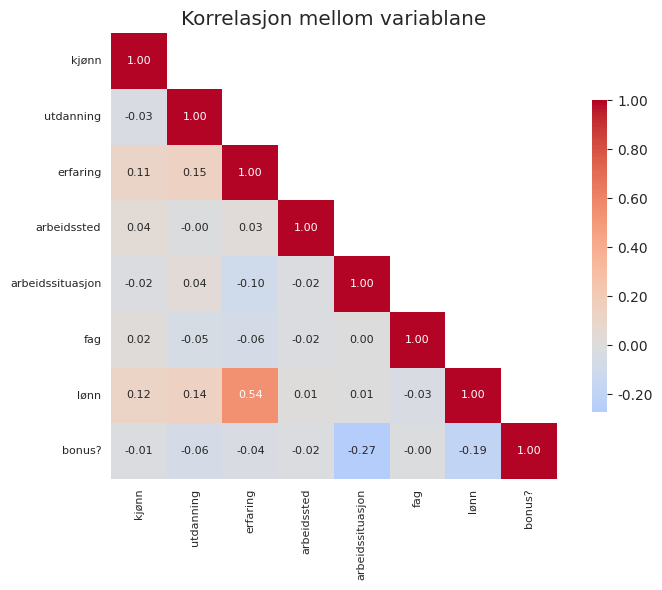

In [20]:
corr_train = dataset.corr(numeric_only=True)
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)

sns.set_style('white')
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    data=corr_train,
    annot=True,
    fmt='.2f',
    mask=mask_train,
    square=True,
    cmap='coolwarm',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={'size': 8},
    center=0,
    ax=ax
)
ax.set_title('Korrelasjon mellom variablane')
ax.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()

# Prediksjon av løn

In [21]:
dataset = pd.read_csv(DATASET_PATH)

In [22]:
dataset

,kjønn,utdanning,erfaring,arbeidssted,arbeidssituasjon,fag,lønn,bonus?
0,mann,4,7,Agder,"in-house, privat sektor",AI / maskinlæring,865000,Nei
1,mann,5,2,Nordland,"in-house, offentlig/kommunal sektor",AI / maskinlæring,756000,Nei
2,mann,4,30,Oslo,konsulent,AI / maskinlæring,1500000,Nei
3,mann,5,25,Oslo,konsulent,AI / maskinlæring,1200000,Nei
4,mann,9,18,Oslo,"in-house, privat sektor",AI / maskinlæring,1200000,Nei
...,...,...,...,...,...,...,...,...
2677,mann,3,14,Vestfold og Telemark,"in-house, offentlig/kommunal sektor",UX / design,720000,Nei
2678,mann,5,8,Vestland,konsulent,UX / design,875000,Nei
2679,mann,0,23,Viken,"in-house, privat sektor",UX / design,1300000,Nei
2680,mann,3,15,Viken,konsulent,UX / design,1000000,Ja


In [23]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2682 entries, 0 to 2681
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   kjønn             2682 non-null   object
 1   utdanning         2682 non-null   int64 
 2   erfaring          2682 non-null   int64 
 3   arbeidssted       2682 non-null   object
 4   arbeidssituasjon  2682 non-null   object
 5   fag               2682 non-null   object
 6   lønn              2682 non-null   int64 
 7   bonus?            2682 non-null   object
dtypes: int64(3), object(5)
memory usage: 167.8+ KB


In [24]:
dataset.describe()

,utdanning,erfaring,lønn
count,2682.000000,2682.000000,2.682000e+03
mean,4.127517,8.568606,8.980438e+05
std,2.842134,7.770099,2.882830e+05
min,0.000000,0.000000,3.000000e+05
25%,3.000000,3.000000,7.000000e+05
50%,3.000000,6.000000,8.500000e+05
75%,5.000000,13.000000,1.020000e+06
max,20.000000,44.000000,2.700000e+06


## Data prosessering

In [25]:
def get_data():
    train = pd.read_csv(DATASET_PATH)
    test = {
        'kjønn': ['mann'],
        'utdanning': [5],
        'erfaring': [2],
        'arbeidssted': ['Vestland'],
        'arbeidssituasjon': ['in-house, privat sektor'],
        'fag': ['backend'],
        'bonus?': ['Ja']
    }

    test = pd.DataFrame(test)

    cat_cols = train.select_dtypes('object').columns.tolist()
    for cat_col in cat_cols:
        train[cat_col] = train[cat_col].astype('category')
        test[cat_col] = test[cat_col].astype('category')
        
    X = train.drop(columns='lønn')
    y = train['lønn']
    X_test = test
    
    return X, y, X_test

In [26]:
X, y, X_test = get_data()
cat_cols = X.select_dtypes('category').columns.tolist()

## Trening av CatBoost

In [27]:
class Trainer:
    def __init__(self, model, X, y, n_splits=N_FOLDS, n_repeats=N_REPEATS):
        self.model = model
        self.X = X
        self.y = y
        self.n_splits = n_splits
        self.n_repeats = n_repeats

    def fit(self, tune=False):
        scores = []        
        skf = KFold(n_splits=self.n_splits, shuffle=True, random_state=SEED)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(self.X, self.y)):
            X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
            y_train, y_val = self.y.iloc[train_idx], self.y.iloc[val_idx]
            
            y_pred = np.zeros_like(y_val, dtype=float)
            
            for i in range(self.n_repeats):
                m = clone(self.model)
                if self.n_repeats > 1:
                    m.set_params(random_state=i)
                m.fit(X_train, y_train)
                y_pred += m.predict(X_val)
                
            y_pred /= self.n_repeats
            
            score = r2_score(y_val, y_pred)
            scores.append(score)
            
            if not tune:
                print(f'--- Fold {fold_idx+1} - R2 Score: {score:.6f}')
            
        if not tune:
            print(f'\n------ Mean R2 Score: {np.mean(scores):.6f}')
            
        return scores
        
    def predict(self, X_test):
        y_pred = np.zeros(len(X_test), dtype=float)
        for i in range(self.n_repeats):
            m = clone(self.model)
            if self.n_repeats > 1:
                m.set_params(random_state=i)
            m.fit(self.X, self.y)
            y_pred += m.predict(X_test)
        y_pred /= self.n_repeats
        return y_pred

In [28]:
model = CatBoostRegressor(verbose=False, cat_features=cat_cols)
trainer = Trainer(model, X, y)
scores = trainer.fit()

--- Fold 1 - R2 Score: 0.522920
--- Fold 2 - R2 Score: 0.510514
--- Fold 3 - R2 Score: 0.537698
--- Fold 4 - R2 Score: 0.568082
--- Fold 5 - R2 Score: 0.439617

------ Mean R2 Score: 0.515766


## Hyperparameter optimalisering

In [29]:
def objective(trial):
    params = {
        'random_strength': trial.suggest_float('random_strength', 0, 1),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 100),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'iterations': trial.suggest_int('iterations', 100, 1000),  
        'random_state': SEED,
        'verbose': False
    }
    
    model = CatBoostRegressor(**params, cat_features=cat_cols)
    trainer = Trainer(model, X, y)
    scores = trainer.fit(tune=True)
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_OPTUNA_TRIALS, n_jobs=-1)

[I 2024-11-18 11:20:03,994] A new study created in memory with name: no-name-6513a30e-ec66-467d-8018-3dd164bc06b7
[I 2024-11-18 11:20:28,316] Trial 2 finished with value: 0.5172426416770286 and parameters: {'random_strength': 0.9422604772737021, 'depth': 9, 'learning_rate': 0.08486657273479586, 'l2_leaf_reg': 6.416069304326405, 'bagging_temperature': 53.38176216089596, 'border_count': 249, 'iterations': 181}. Best is trial 2 with value: 0.5172426416770286.
[I 2024-11-18 11:21:03,474] Trial 4 finished with value: 0.5184712546385353 and parameters: {'random_strength': 0.542165888466867, 'depth': 6, 'learning_rate': 0.06280124827775767, 'l2_leaf_reg': 9.981301485637424, 'bagging_temperature': 86.97027674100843, 'border_count': 105, 'iterations': 315}. Best is trial 4 with value: 0.5184712546385353.
[I 2024-11-18 11:21:25,146] Trial 0 finished with value: 0.5108142516335554 and parameters: {'random_strength': 0.6123801007473814, 'depth': 5, 'learning_rate': 0.09234117095036157, 'l2_leaf_re

## Prediksjon med nye hyperparameterar

In [30]:
params = {
    **study.best_params,
    'random_state': SEED,
    'verbose': False
}
print(json.dumps(params, indent=4))

{
    "random_strength": 0.9061147354786995,
    "depth": 10,
    "learning_rate": 0.048396583323984416,
    "l2_leaf_reg": 7.488212898497864,
    "bagging_temperature": 26.299401657817683,
    "border_count": 195,
    "iterations": 441,
    "random_state": 42,
    "verbose": false
}


In [31]:
model = CatBoostRegressor(cat_features=cat_cols, **params)
trainer = Trainer(model, X, y)
scores = trainer.fit()

--- Fold 1 - R2 Score: 0.528966
--- Fold 2 - R2 Score: 0.527011
--- Fold 3 - R2 Score: 0.542447
--- Fold 4 - R2 Score: 0.571047
--- Fold 5 - R2 Score: 0.454565

------ Mean R2 Score: 0.524807


In [32]:
preds = trainer.predict(X_test)
print(f'Predikta løn: {preds[0]:,.0f} NOK')

Predikta løn: 712,856 NOK


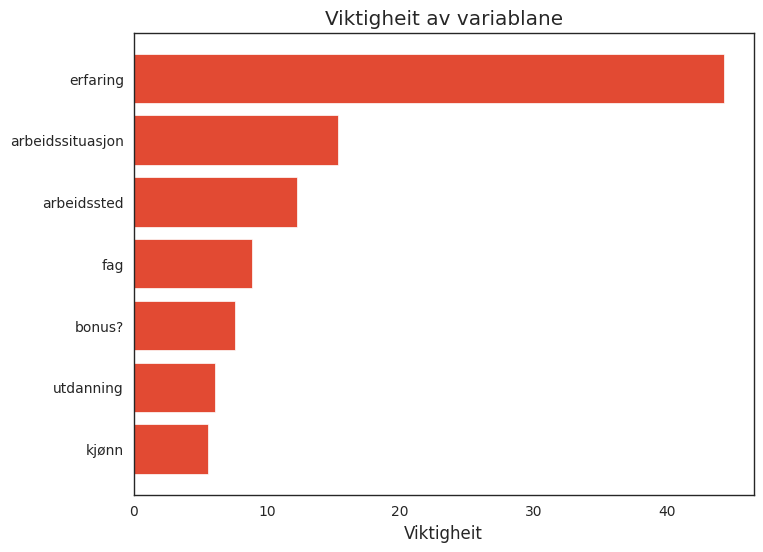

In [33]:
model = CatBoostRegressor(cat_features=cat_cols, **params)
model.fit(X, y)

feature_importance = model.get_feature_importance()
feature_names = X.columns
sorted_idx = np.argsort(feature_importance)

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
ax.set_yticks(range(len(sorted_idx)))
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_xlabel('Viktigheit')
ax.set_title('Viktigheit av variablane')
plt.show()